In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import astropy.stats as aps
import astropy.io.fits as pf
from astropy.time import Time

from skyfield.units import Angle
from skyfield.api import load, wgs84, EarthSatellite 
    

rootdir = '/Users/peter/Projects/starlink_data/'
datadir = rootdir + 'full_data/'
testdir = rootdir + 'test_data/'
savedir = rootdir + 'images/results/'


starlink_ref = pd.read_pickle(f'{rootdir}starlink_names.p')


eph = load('de421.bsp')

In [2]:
def get_data(category):
    
    if category=='passages':
        files = sorted(glob.glob(f'{datadir}passages_*.p'))
        
    if category=='passed':
        files = sorted(glob.glob(f'{datadir}passed_*.p'))
    
    if category=='vmags':
        files = sorted(glob.glob(f'{datadir}vmags_july/vmags_*.p'))
        
    if category=='errors':
        files = sorted(glob.glob(f'{datadir}vmag_errors_*.p'))
        
    if category=='pools':
        files = sorted(glob.glob(f'{datadir}pool_*.p'))
        
    return files


# =================================================================================


def reduce_passages(camid):
    
    all_passages = pd.read_pickle(f'{datadir}passages_20221023{camid}.p')
    pool = pd.read_pickle(f'{datadir}pool_{camid}.p')

    passages = {}
    for lstseq, data in all_passages.items():
        if lstseq in pool:
            passages[lstseq] = {}
            for satnum in pool[lstseq]:
                if satnum in data:
                    passages[lstseq][satnum] = data[satnum]
                    
    return passages


# =================================================================================


def get_starlink_tles():
    
    # Load TLEs for all satellite passages
    satfiles = f"{testdir}3leComplete.txt"
    with open(satfiles) as f:
        all_tles = f.readlines()
        f.close()

    # Split TLE list into individual lists for each TLE
    all_tles = [i.strip() for i in all_tles]
    tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

    # Reduce TLEs to Starlink only
    starlink_tles = []
    for tle in tles:
        if "STARLINK" in tle[0]:
            starlink_tles.append(tle)
            
    for tle in starlink_tles:
        tle[0] = tle[0][2:]
        
    return starlink_tles


# =================================================================================


def get_starlink_launches():
    """
    For the scraping: probably not the best way, but essentially just adds everything to a list.
    Thinking have it this way such that it just needs to be run once.
    
    """
    
    import requests
    from bs4 import BeautifulSoup
    
    base_url = 'https://nssdc.gsfc.nasa.gov/nmc/spacecraft/query'
    search_params = {'name': 'starlink'}

    # Send a GET request to the website
    response = requests.get(base_url, params=search_params)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    
    # Index 0: Name         ...  Starlink 1007
    # Index 1: NSSDCA ID    ...  2019-074A
    # Index 2: Launch date  ...  2019-11-11 (Y:M:D)
    
    i=0
    names = []
    dates = []

    # Find the table rows that contain satellite data
    for row in soup.find_all('td'):
        entry = row.get_text()
        i+=1
        if i==1:
            entry = entry.upper().replace(' ', '-') #since my data is uppercase and hyphenated
            names.append(entry)
        if i==2:
            continue
        if i==3:
            dates.append(entry)
            i=0
            
    df = pd.DataFrame({'name': names, 'launch': dates})
    df['launch'] = pd.to_datetime(df['launch'])
    

    starlink_tles = get_starlink_tles()
        
        
    # DarkSat = Starlink-1130 = 44932U
    # Visors - 7 August 2020
    # Visors removed - 14 September 2021 onwards
    # V1.5 - 30 June 2021 onwards
    # V2-mini: 27 February 2023, 19 April 2023, 19 May 2023 ---> out of our date range
    
    
    df2 = pd.DataFrame(columns=['starlink', 'satnum', 'launch', 'version', 'type'])
    for i, tle in enumerate(starlink_tles):
        starlink = tle[0]
        try:
            idx = np.where(df.name.values == starlink)[0][0]
        except:
            continue
        satnum = tle[1].split()[1]
        date = df.launch.iloc[idx]
        satname = df.name.iloc[idx]

        # v0.1
        if date < pd.to_datetime('2018-02-23'):
            version = '0.1'
            sattype = 'tintin'

        # v0.9
        if date > pd.to_datetime('2018-02-23') and date < pd.to_datetime('2019-11-12'):
            version = '0.9'
            sattype = 'standard'

        # v1.0
        if date > pd.to_datetime('2019-11-12') and date < pd.to_datetime('2021-05-27'):
            version = '1.0'
            if satnum == '44932U':
                sattype = 'darksat'
            elif date > pd.to_datetime('2020-06-30'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'

        # v1.5
        if date > pd.to_datetime('2021-05-27'):
            version = '1.5'
            if date < pd.to_datetime('2021-09-13'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'


        row_data = [satname, satnum, date, version, sattype]
        df2.loc[len(df2)] = row_data
    
    return df2


# =================================================================================


def observation_info():
    
    df = get_starlink_launches()
    passages = get_data(category='passages')
    
    ### Timerange of observations
    for psg in passages:
        p = pd.read_pickle(psg)
        camid = psg[-5:-2]

        # JD of first observation
        lstseq0 = list(p)[0]
        sat0 = list(p[lstseq0])[0]
        jd0 = p[lstseq0][sat0]['start']['jd']

        # JD of last observation
        lstseq1 = list(p)[-1]
        sat1 = list(p[lstseq1])[0]
        jd1 = p[lstseq1][sat1]['end']['jd']

        t0 = Time(jd0, format='jd', scale='utc')
        t1 = Time(jd1, format='jd', scale='utc')
        time_diff = t1 - t0
        print(f"{camid} - time range spanned: {time_diff.to('hour')} ... {t0.iso} to {t1.iso}")
    
    
    ### Unique Starlinks
    
    vmags = get_data(category='vmags')
    all_sats = []
    for vmag in vmags:
        
        camid = vmag[-5:-2]
        v = pd.read_pickle(vmag)
        sats = []
        for lstseq in v:
            sats.extend(list(v[lstseq])[2:])
            
        all_sats.extend(sats)
        unique_sats = list(set(sats)) 
        print(f'{camid}: {len(sats)} observations;  {len(unique_sats)} unique starlinks')
        
    all_unique_sats = list(set(all_sats))
    print(f'\n{len(all_sats)} total observations  -  {len(all_unique_sats)} unique Starlinks\n')
    
    
    ### Type of Starlinks
    
    version = []
    sat_types = []
    for satnum in all_sats:
        sat_types.append(df.loc[df['satnum'] == satnum].type.values[0])
        version.append(df.loc[df['satnum'] == satnum].version.values[0])
    

    version_unique = []    
    sat_types_unique = []
    for satnum in all_unique_sats:
        sat_types_unique.append(df.loc[df['satnum'] == satnum].type.values[0])
        version_unique.append(df.loc[df['satnum'] == satnum].version.values[0])
        
    print(f"Standard:   {sat_types.count('standard')}  -   {sat_types_unique.count('standard')}")
    print(f"VisorSat:   {sat_types.count('visorsat')}   -   {sat_types_unique.count('visorsat')}")
    print(f"DarkSats:   {sat_types.count('darksat')}     -   {sat_types_unique.count('darksat')}\n")
    
    # Total
    count = {}
    x = list(zip(sat_types, version))
    print('For all observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
            
    print('\n')
    
    # Unique
    count = {}
    x = list(zip(sat_types_unique, version_unique))
    print('For unique observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
    

# =================================================================================
    

def get_siteinfo():
    confdir = '/Users/Peter/Projects/starlink_data/fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == 'LS'
    siteinfo = siteinfo[mask]
    return siteinfo


# =================================================================================


def error_prop(flux, sigma_F, sigma_B):
    dm_dF = -2.5/(flux*np.log(10))
    dm_dB = 1
    return np.sqrt((dm_dF*sigma_F)**2 + (dm_dB*sigma_B)**2)


# =================================================================================


def compute_vmag_errors():
    
    all_vmags  = []
    all_deltas = []
    camids = ['LSC','LSN','LSS','LSE','LSW']
    
    sigma_F = 0.08658855727735504
    
    for camid in camids:
        vmags = pd.read_pickle(f'{datadir}vmags_{camid}.p')
        
        for lstseq in vmags.keys():
            for sat in list(vmags[lstseq])[2:]:
                vmag = vmags[lstseq][sat]['vmag']
                flux = vmags[lstseq][sat]['flux']
                sigma_B = vmags[lstseq][sat]['sigma_B']
                delta = error_prop(flux, sigma_F, sigma_B)
                
                all_vmags.append(vmag)
                all_deltas.append(delta)
                        
    return all_vmags, all_deltas


# =================================================================================


def create_dataframe():
    
    # ALL IMPORTANT INFO IN ONE DATAFRAME!!!
    
    d = {}
    vmag_files = sorted(glob.glob(f'{datadir}vmags_*'))
    sigma_F = 0.08658855727735504
    
    satinfo = get_starlink_launches()
    
    for file in vmag_files:
        camid = file[-5:-2]
        vmags = pd.read_pickle(file)
        
        all_sats = []
        for lstseq in vmags:
            all_sats.extend(list(vmags[lstseq])[2:])
        sats = list(set(all_sats)) 

        # Creating a dictionary where each key is a unique satellite
        satdict = {}
        for satnum in sats:
            satdict[satnum] = {
                'satname':[], 'vmag':[], 'delta':[], 'jd0':[], 'jd1':[], 
                'camid':[], 'type':[], 'version':[], 'launch':[]
            }
        
        for lstseq in vmags:
            satnums = list(vmags[lstseq])[2:]
            for satnum in satnums:
                if satnum in satdict.keys():
                    
                    jd0 = vmags[lstseq]['JD0']
                    jd1 = vmags[lstseq]['JD1']
                    vmag = vmags[lstseq][satnum]['vmag']
                    satname = vmags[lstseq][satnum]['name']
                    
                    flux = vmags[lstseq][satnum]['flux']
                    sigma_B = vmags[lstseq][satnum]['sigma_B']
                    delta = error_prop(flux, sigma_F, sigma_B)
                    
                    launch = satinfo.loc[satinfo['satnum'] == satnum].launch.values[0]
                    sattype = satinfo.loc[satinfo['satnum'] == satnum].type.values[0]
                    version = satinfo.loc[satinfo['satnum'] == satnum].version.values[0]

                    satdict[satnum]['jd0'].append(jd0)
                    satdict[satnum]['jd1'].append(jd1)                                        
                    satdict[satnum]['vmag'].append(vmag)
                    satdict[satnum]['delta'].append(delta)
                    satdict[satnum]['camid'].append(camid)
                    satdict[satnum]['type'].append(sattype)
                    satdict[satnum]['launch'].append(launch)
                    satdict[satnum]['version'].append(version)
                    satdict[satnum]['satname'].append(satname)
                    
            
        d[camid] = pd.DataFrame([
            (satnum, satname, vmag, delta, jd0, jd1, camid, sattype, version, launch) \
            for satnum, vals in satdict.items() \
            for satname, vmag, delta, jd0, jd1, camid, sattype, version, launch in zip(
                vals['satname'], vals['vmag'], vals['delta'], vals['jd0'], vals['jd1'], 
                vals['camid'], vals['type'], vals['version'], vals['launch']
            )], columns=['satnum', 'satname', 'vmag', 'delta', 'JD0', 'JD1', 'camid', 'type', 'version', 'launch']
        )
    
    df = pd.concat(d.values(), ignore_index=True)
    
    # ------
    
    starlink_tles = get_starlink_tles() 
    eph = load('de421.bsp')
    sun = eph['sun']
    earth = eph['earth']
    
    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + earth
    
    sorted_df = df.sort_values('JD0')
    for index, row in sorted_df.iterrows():
        t = row['JD0']
        obs_time = ts.ut1_jd(t)
        
        # Sun position
        astro = observer.at(obs_time).observe(sun)
        app = astro.apparent()
        alt, az, dist = app.altaz()
        df.loc[index, 'sun_alt'] = alt.degrees
        df.loc[index, 'sun_az'] = az.degrees
        
        satname = row.satname
        for tle in starlink_tles:
            if satname in tle[0]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts) 
                
                # Inclination
                inc = sat.model.inclo
                inc = Angle(radians=inc).degrees
                df.loc[index, 'inc'] = inc
                
                # Position - altaz
                diff = sat - mascara
                topocentric = diff.at(obs_time)
                alt, az, dist = topocentric.altaz()
                df.loc[index, 'alt'] = alt.degrees
                df.loc[index, 'az'] = az.degrees
                df.loc[index, 'range'] = dist.km
                
                # Position - radec
                ra, dec, _ = topocentric.radec() 
                df.loc[index, 'ra'] = ra.hours
                df.loc[index, 'dec'] = dec.degrees
                
                # Height
                geocentric = sat.at(obs_time)
                height = wgs84.height_of(geocentric)
                df.loc[index, 'height'] = height.km
                
                # Phase angle            
                sat_pov = earth + sat
                phase_angle = sat_pov.at(obs_time).observe(observer).phase_angle(sun)
                df.loc[index, 'phase_angle'] = phase_angle.degrees
                
                """
                phase_angle(): given an illuminator (usually the Sun) as their argument, compute 
                the angle Sun-target-observer. Returns the Angle from the body’s point of view between 
                light arriving from the Sun and the light departing toward the observer. This angle is 0° 
                if the observer is in the same direction as the Sun and sees the body as fully illuminated, 
                and 180° if the observer is behind the body and sees only its dark side
                """

                break   
            
                
    # Normalize the magnitudes to a fixed range of 550 km
    # THIS IS NOT A LINEAR ADJUSTMENT!
    # The factor for adjusting the apparent magnitudes from the actual range to a standard distance 
    # determined based on the inverse square law of light!
    
    # Note, this is also how the Zwicky paper does it! m_550 = m - 5*log10(r/550)
    
    #df['delta_norm'] = np.sqrt(df['delta']**2 + (2.5 * np.log10(factor) * np.log(10) * df['delta'])**2)
    
    
    df['vmag_norm_550'] = df['vmag'] - 5 * np.log10(df['range']/550.)
    df['vmag_norm_1000'] = df['vmag'] - 5 * np.log10(df['range']/1000.)


    return df


# =================================================================================




# Stats

In [3]:
observation_info()

LSC - time range spanned: 8.65719048678875 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
LSE - time range spanned: 8.65719049796462 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
LSN - time range spanned: 8.657191067934036 h ... 2022-10-24 00:23:19.417 to 2022-10-24 09:02:45.305
LSS - time range spanned: 8.657190531492233 h ... 2022-10-24 00:23:19.419 to 2022-10-24 09:02:45.305
LSW - time range spanned: 8.657190799713135 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.305
LSC: 167 observations;  36 unique starlinks
LSE: 422 observations;  67 unique starlinks
LSN: 109 observations;  20 unique starlinks
LSS: 450 observations;  65 unique starlinks
LSW: 457 observations;  63 unique starlinks

1605 total observations  -  175 unique Starlinks

Standard:   1245  -   117
VisorSat:   358   -   57
DarkSats:   2     -   1

For all observations:

visorsat:
  1.0: 358
standard:
  1.5: 667
  1.0: 454
  0.9: 124
darksat:
  1.0: 2


For unique observations:

standard:
  1.5: 

In [116]:
def full_sat_pop_stats():
        
    df = get_starlink_launches()
    passage_files = sorted(glob.glob(f'{rootdir}passages_all_sats/passages_*.p'))
    passed_files = sorted(glob.glob(f'{rootdir}passages_all_sats/passed_*.p'))
    
    combined_sats = []
    combined_starlinks = []

    for (a,b) in zip(passage_files, passed_files):
        camid = a[-5:-2]
        p = pd.read_pickle(a)
        p_sats = pd.read_pickle(b)
        
        print(camid)

        # JD of first observation
        lstseq0 = list(p.keys())[0]
        sat0 = list(p[lstseq0].keys())[0]
        jd0 = p[lstseq0][sat0]['start']['jd']

        # JD of last observation
        lstseq1 = list(p.keys())[-1]
        sat1 = list(p[lstseq1].keys())[0]
        jd1 = p[lstseq1][sat1]['end']['jd']

        t0 = Time(jd0, format='jd', scale='utc')
        t1 = Time(jd1, format='jd', scale='utc')
        time_diff = t1 - t0
        print(f"Time range spanned: {time_diff.to('hour')} ... {t0.iso} to {t1.iso}")

        all_sats = []
        for lstseq in p.keys():
            all_sats.extend(list(p[lstseq].keys()))

        print('Total number of passed satellites: ', len(all_sats))
        print('Number of unique passed satellites: ', len(np.unique(all_sats)))

        starlink_passages_satnums = []
        for satnum in df.satnum:
            if satnum in p_sats.keys():
                starlink_passages_satnums.append(satnum)

        print('Total number of starlinks passing overhead: ', len(starlink_passages_satnums))
        print('Number of unique starlinks passing overhead: ', len(np.unique(starlink_passages_satnums)))
        print('\n')
        
        combined_sats.extend(all_sats)
        combined_starlinks.extend(starlink_passages_satnums)
    
    print('Across all cameras:')
    print('Combined total number of satellites: ', len(combined_sats))
    print('Combined number of unique satellites: ', len(np.unique(combined_sats)))
    print('\n')
    print('Combined total number of starlinks: ', len(combined_starlinks))
    print('Combined number of unique starlinks: ', len(np.unique(combined_starlinks)))

full_sat_pop_stats()

LSC
Time range spanned: 8.65719048678875 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
Total number of passed satellites:  557870
Number of unique passed satellites:  7021
Total number of starlinks passing overhead:  880
Number of unique starlinks passing overhead:  880


LSE
Time range spanned: 8.65719049796462 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
Total number of passed satellites:  1446144
Number of unique passed satellites:  8969
Total number of starlinks passing overhead:  1335
Number of unique starlinks passing overhead:  1335


LSN
Time range spanned: 8.657191067934036 h ... 2022-10-24 00:23:19.417 to 2022-10-24 09:02:45.305
Total number of passed satellites:  2591604
Number of unique passed satellites:  10162
Total number of starlinks passing overhead:  1303
Number of unique starlinks passing overhead:  1303


LSS
Time range spanned: 8.657190531492233 h ... 2022-10-24 00:23:19.419 to 2022-10-24 09:02:45.305
Total number of passed satellites:  55255

In [123]:
def how_many_starlinks():
    
    starlink_tles = get_starlink_tles()
    camids = ['LSC','LSN','LSS','LSE','LSW']
    
    n_images = 0
    img_counts = 0
    all_satnums = []
    for camid in camids: 
        p = reduce_passages(camid)
        
        img_count = 0
        satnums = []
        for lstseq in p.keys():
            if len(list(p[lstseq])) != 0:
                img_count += 1
                satnums.extend(list(p[lstseq]))
          
        print(f'{camid}: {len(satnums)} starlinks in {img_count} images')
        all_satnums.extend(satnums)
        img_counts += img_count
        n_images += len(p.keys())
    
    print('\nTotal:', len(all_satnums))
    print('Unique:', len(np.unique(all_satnums)))
    print('Number of images:', n_images)
    print('Number of affected images:', img_counts)
    
    
how_many_starlinks()

LSC: 496 starlinks in 393 images
LSN: 750 starlinks in 404 images
LSS: 2915 starlinks in 1024 images
LSE: 1468 starlinks in 593 images
LSW: 1870 starlinks in 656 images

Total: 7499
Unique: 473
Number of images: 3070
Number of affected images: 3070


# Plots

In [6]:
df = create_dataframe()

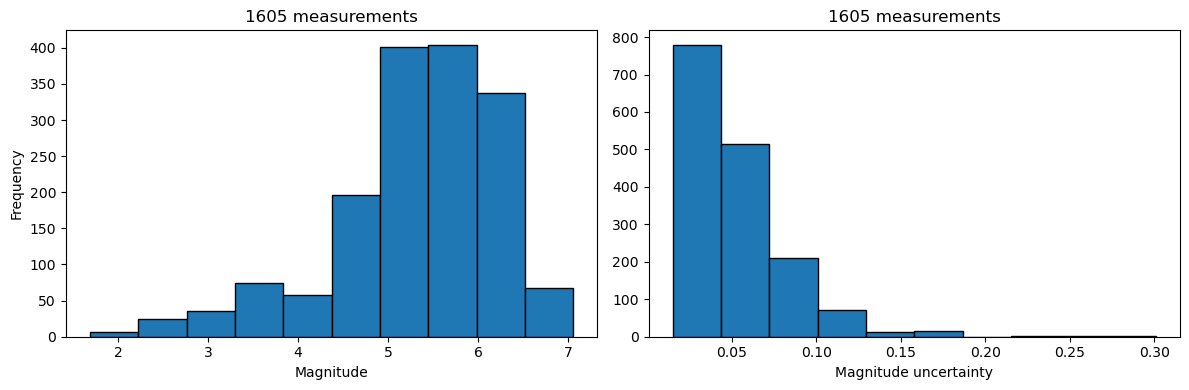

In [76]:
def hist():
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[12,4])

    ax1.hist(df.vmag, ec='k')
    ax1.set_title(f'{len(df)} measurements')
    ax1.set_xlabel('Magnitude')
    ax1.set_ylabel('Frequency')
    ax2.hist(df.delta, ec='k')
    ax2.set_title(f'{len(df)} measurements')
    ax2.set_xlabel('Magnitude uncertainty')
    
    plt.tight_layout()
    plt.show()
    
hist()

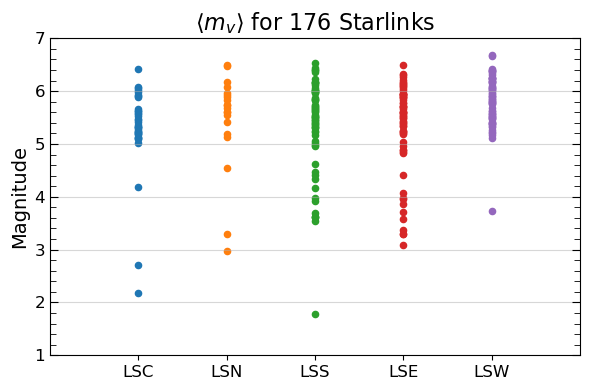

In [35]:
def camid_avg_vmag():
    
    fig, ax = plt.subplots(1, 1, figsize=[6,4])

    camids = ['LSC', 'LSN', 'LSS', 'LSE', 'LSW']
    for i, camid in enumerate(camids):

        vmags = []
        subset = df[df['camid']==camid][['satnum', 'vmag']]

        for satnum in subset.satnum.unique():
            sat_vmag = np.mean(subset[subset['satnum']==satnum].vmag.values)
            vmags.append(sat_vmag)

        ax.scatter(np.ones(len(vmags))+i, vmags, s=20)

    ax.set_xticks([1,2,3,4,5], camids)
    ax.set_ylim([1, 7])
    ax.set_xlim([0, 6])
    ax.set_title(r'$\langle m_v \rangle$ for {} Starlinks'.format(len(df.satnum.unique())), fontsize=16)
    ax.set_ylabel('Magnitude', fontsize=14)

    ax.tick_params(axis='y', which='both', right=True, direction='in')
    ax.tick_params(axis='y', which='major', length=6)
    ax.tick_params(axis='y', which='minor', length=4)
    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.yaxis.grid(alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()
    
camid_avg_vmag()

All:  1605 ; mean = 5.316642710620059
Standard:  1247 ; mean = 5.380386107768826
VisorSat:  356 ; mean = 5.088151646090843
DarkSat:  2 ; mean = 6.244044074564632


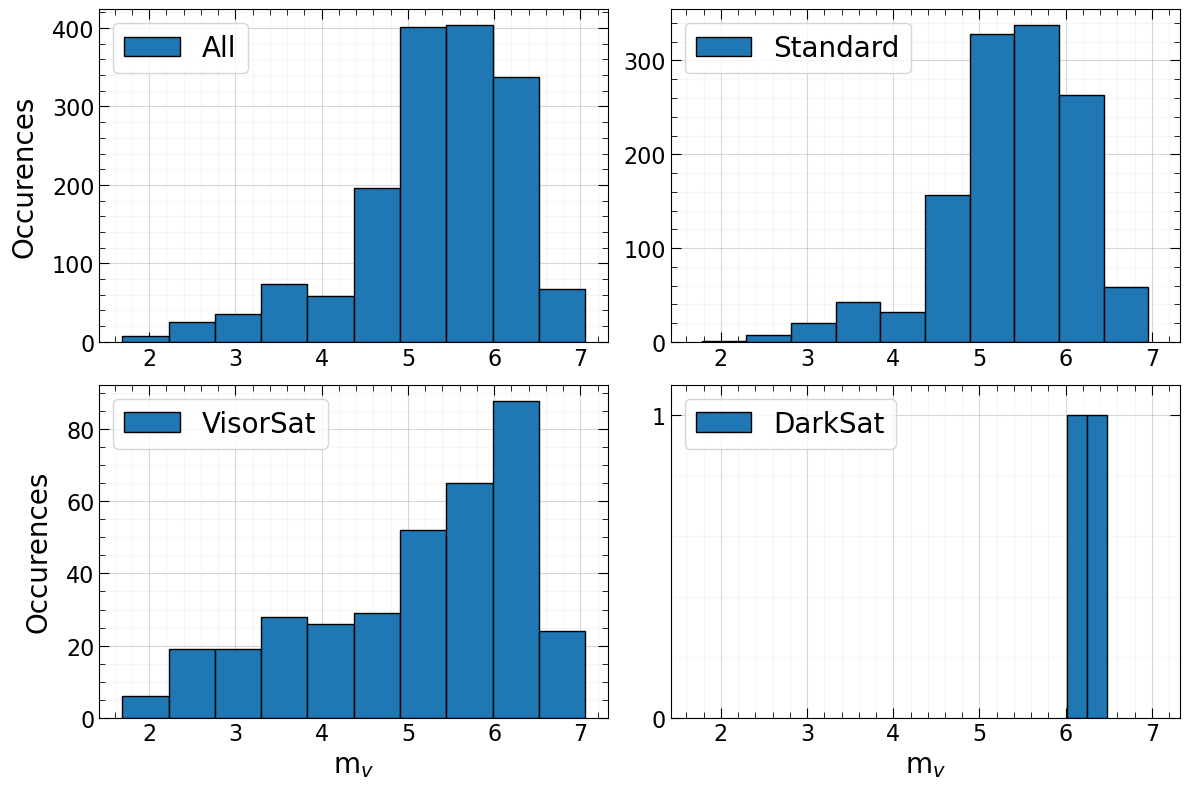

In [77]:
def hist_sattypes(savefig=False):
    
    fig, axs = plt.subplots(2, 2, figsize=[12,8], sharex=False)
    
    stand = df[df.type=='standard'].vmag
    visor = df[df.type=='visorsat'].vmag
    dark = df[df.type=='darksat'].vmag
                        
    n_bins = 10   
    axs[0,0].hist(df.vmag, n_bins, fc='C0', ec='k', zorder=2, label='All')
    axs[0,1].hist(stand, n_bins, fc='C0', ec='k', zorder=2, label='Standard')
    axs[1,0].hist(visor, n_bins, fc='C0', ec='k', zorder=2, label='VisorSat')
    axs[1,1].hist(dark, 2, fc='C0', ec='k', zorder=2, label='DarkSat')
    
    for ax in axs.flat:
        ax.legend(fontsize=20)
    
    print('All: ', len(df.vmag), '; mean =', np.mean(df.vmag))
    print('Standard: ', len(stand), '; mean =', np.mean(stand))
    print('VisorSat: ', len(visor), '; mean =', np.mean(visor))
    print('DarkSat: ', len(dark), '; mean =', np.mean(dark))
    
    for ax in axs.ravel()[0:3]:
        ax.minorticks_on()
        ax.set_xlim(axs[0,0].get_xlim())
        ax.tick_params(axis='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=7, labelsize=16)
        ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.grid(alpha=0.5, which='both', zorder=1)
        ax.grid(which='minor', alpha=0.1, zorder=1)
    
    axs[0,0].set_ylabel('Occurences', labelpad=10, fontsize=20)
    axs[1,0].set_ylabel('Occurences', labelpad=10, fontsize=20)
    axs[1,0].set_xlabel(r'm$_v$', fontsize=20)
    axs[1,1].set_xlabel(r'm$_v$', fontsize=20)  
    
    ax4 = axs[1,1]
    ax4.minorticks_on()
    ax4.yaxis.set_major_locator(ticker.FixedLocator([0, 1]))
    ax4.set_yticklabels([0,1])
    ax4.set_xlim(axs[0,0].get_xlim())
    ax4.set_ylim([0,1.1])
    ax4.tick_params(axis='both', direction='in', top=True, right=True)
    ax4.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax4.tick_params(axis='x', which='minor', length=4)
    ax4.tick_params(axis='y', which='minor', left=False, right=False)
    ax4.tick_params(axis='x', which='minor', top=True, direction='in')
    ax4.grid(alpha=0.5, which='both', zorder=1)
    ax4.grid(which='minor', alpha=0.1, zorder=1)
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist.png', dpi=300, bbox_inches='tight')
    plt.show()
    
hist_sattypes(savefig=True)

0.05157770035405639
0.05133049272200455
0.052468710805333836
0.04711179861100349


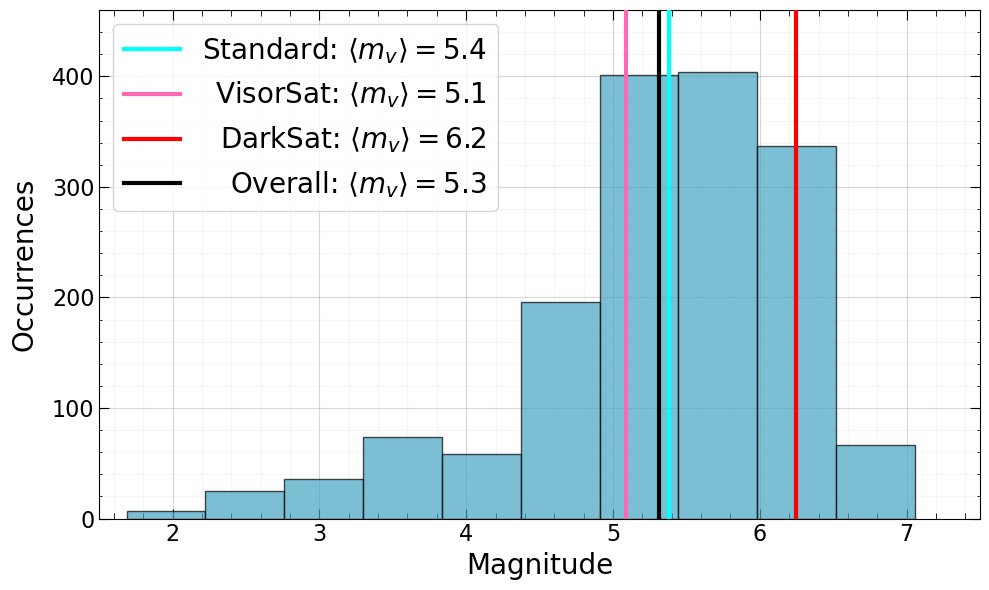

In [170]:
 def hist_averages(savefig=False):

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    standard = df[df.type=='standard'][['vmag', 'delta']]
    visors  = df[df.type=='visorsat'][['vmag', 'delta']]
    darksat = df[df.type=='darksat'][['vmag', 'delta']]
    
    print(np.mean(df.delta))
    print(np.mean(standard.delta))
    print(np.mean(visors.delta))
    print(np.mean(darksat.delta))
                        
    n_bins = 10
    ax.hist(df.vmag.values, n_bins, fc='#44a5c2', alpha=0.7, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(standard.vmag), c='cyan', lw=3, zorder=3,
              label=r'Standard: $\langle m_v \rangle = {}$'.format(round(np.mean(standard.vmag), 1)))
    
    ax.axvline(np.mean(visors.vmag), c='hotpink', lw=3, zorder=3,
              label=r'VisorSat: $\langle m_v \rangle = {}$'.format(round(np.mean(visors.vmag), 1))) 
    
    ax.axvline(np.mean(darksat.vmag), c='red', lw=3, zorder=3,
              label=r'DarkSat: $\langle m_v \rangle = {}$'.format(round(np.mean(darksat.vmag), 1)))
    
    ax.axvline(np.mean(df.vmag), c='k', lw=3, zorder=3,
              label=r'Overall: $\langle m_v \rangle = {}$'.format(round(np.mean(df.vmag), 1))) 

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Magnitude', fontsize=20)
    leg = ax.legend(fontsize=20, facecolor='w')
    
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))
        
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 460])
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_types.png', dpi=300, bbox_inches='tight')
    plt.show()
    
hist_averages(savefig=True)

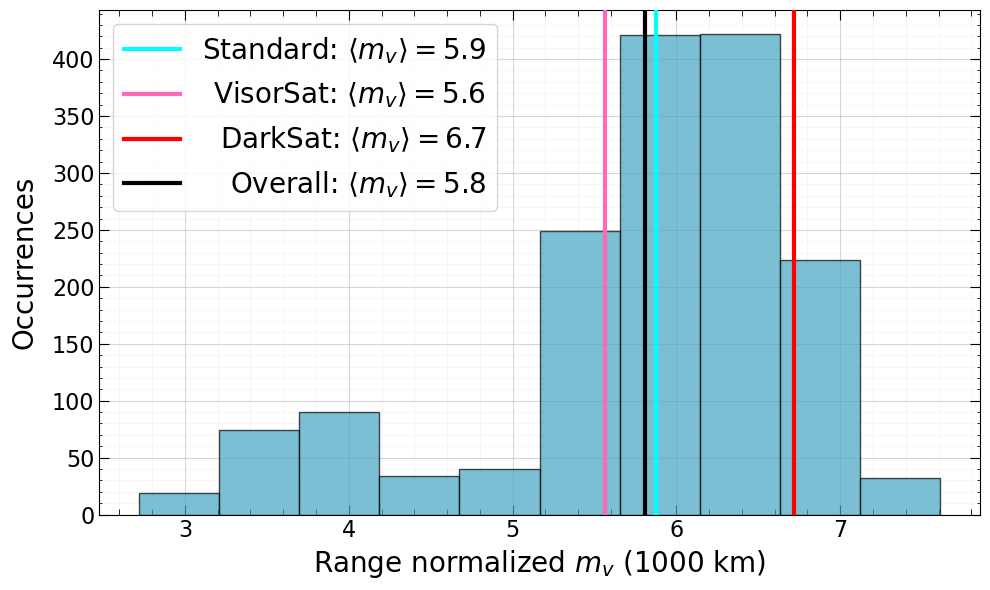

In [38]:
 def hist_averages_norm(normtype, savefig=False):

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    column = f'vmag_norm_{normtype}'
    
    standard = df[df.type=='standard'][[column]]
    visors  = df[df.type=='visorsat'][[column]]
    darksat = df[df.type=='darksat'][[column]]
                        
    n_bins = 10
    ax.hist(df[column], n_bins, fc='#44a5c2', alpha=0.7, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(standard[column]), c='cyan', lw=3, zorder=3,
              label=r'Standard: $\langle m_v \rangle = {}$'.format(round(np.mean(standard[column]), 1)))
    
    ax.axvline(np.mean(visors[column]), c='hotpink', lw=3, zorder=3,
              label=r'VisorSat: $\langle m_v \rangle = {}$'.format(round(np.mean(visors[column]), 1))) 
    
    ax.axvline(np.mean(darksat[column]), c='red', lw=3, zorder=3,
              label=r'DarkSat: $\langle m_v \rangle = {}$'.format(round(np.mean(darksat[column]), 1)))
    
    ax.axvline(np.mean(df[column]), c='k', lw=3, zorder=3,
              label=r'Overall: $\langle m_v \rangle = {}$'.format(round(np.mean(df[column]), 1))) 

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel(f'Range normalized $m_v$ ({normtype} km)', fontsize=20)
    leg = ax.legend(fontsize=20, facecolor='w')
    
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_types_norm_{normtype}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
hist_averages_norm(normtype='1000', savefig=True)

All:  1247 ; mean = 5.380386107768826 ; delta = 0.030518462280221766
v0.9:  123 ; mean = 5.459786052466992 ; delta = 0.020176630646838098
v1.0:  453 ; mean = 5.369271740865904 ; delta = 0.031031445183710735
v1.5:  671 ; mean = 5.373334863371135 ; delta = 0.031617233736487164


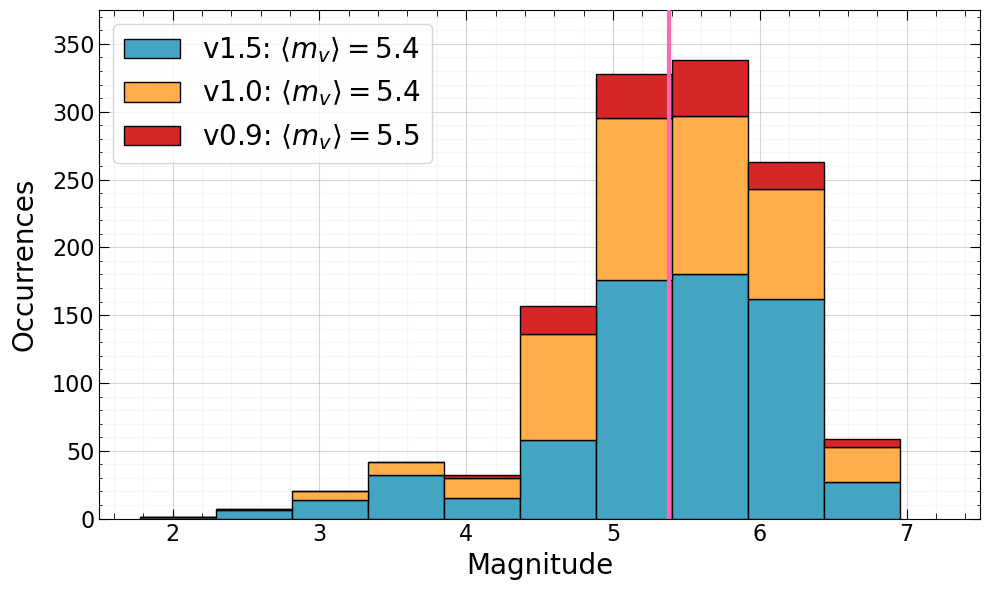

In [80]:
def hist_stacked_versions(savefig=False):
    
    fig, ax = plt.subplots(1, 1, figsize=[10,6])

    n_bins = 10  
    stan = df[df.type=='standard']           
    v09 = stan[stan.version=='0.9'].vmag
    v10 = stan[stan.version=='1.0'].vmag
    v15 = stan[stan.version=='1.5'].vmag
    v09d = stan[stan.version=='0.9'].delta
    v10d = stan[stan.version=='1.0'].delta
    v15d = stan[stan.version=='1.5'].delta
    
    print('All: ', len(stan.vmag), '; mean =',np.mean(stan.vmag), '; delta =',np.std(stan.delta))
    print('v0.9: ', len(v09), '; mean =', np.mean(v09), '; delta =', np.std(v09d))
    print('v1.0: ', len(v10), '; mean =', np.mean(v10), '; delta =', np.std(v10d))
    print('v1.5: ', len(v15), '; mean =', np.mean(v15), '; delta =', np.std(v15d))
    cols = ['#44a5c2', '#ffae49', 'C3' ]
    labs = [r'v1.5: $\langle m_v \rangle = {}$'.format(round(np.mean(v15),1)),
            r'v1.0: $\langle m_v \rangle = {}$'.format(round(np.mean(v10),1)),
            r'v0.9: $\langle m_v \rangle = {}$'.format(round(np.mean(v09),1))]
    
    ax.hist([v15,v10,v09], bins=n_bins, color=cols, label=labs, ec='k', stacked=True, zorder=2)
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(stan.vmag), c='hotpink', lw=3, zorder=3)
    # label=r'Overall: $\langle m_v \rangle = {}$'.format(round(np.mean(stan.vmag),1))
    
    ax.legend(fontsize=20, frameon=True)

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel(r'Magnitude', fontsize=20)
    
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 375])  

    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_versions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
hist_stacked_versions(savefig=True)

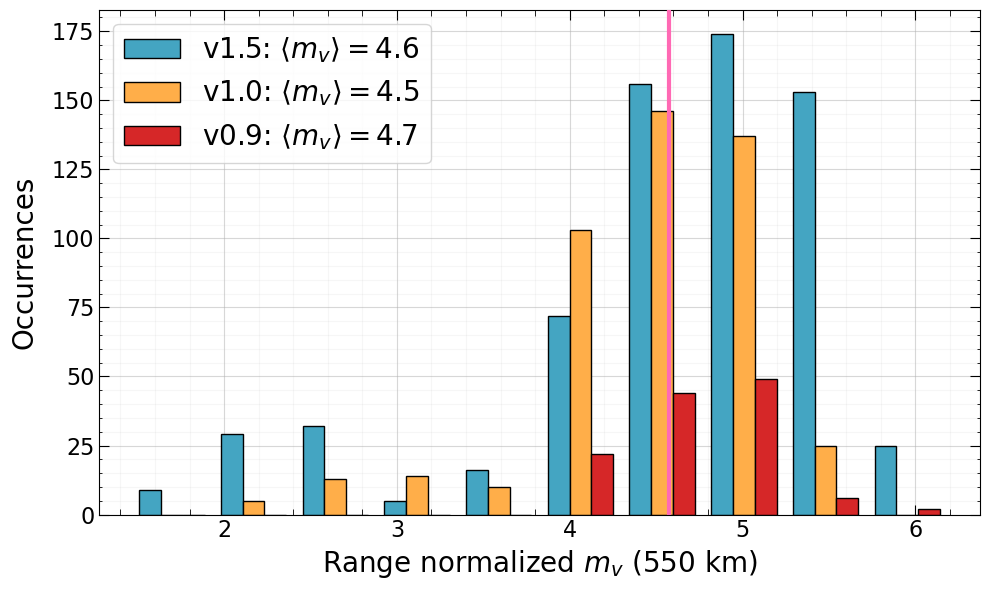

In [10]:
def hist_stacked_versions(normtype='550', savefig=False):
    
    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    column = f'vmag_norm_{normtype}'
     
    stan = df[df.type=='standard']           
    v09 = stan[stan.version=='0.9'][column]
    v10 = stan[stan.version=='1.0'][column]
    v15 = stan[stan.version=='1.5'][column]
    
    cols = ['#44a5c2', '#ffae49', 'C3' ]
    labs = [r'v1.5: $\langle m_v \rangle = {}$'.format(round(np.mean(v15),1)),
            r'v1.0: $\langle m_v \rangle = {}$'.format(round(np.mean(v10),1)),
            r'v0.9: $\langle m_v \rangle = {}$'.format(round(np.mean(v09),1))]
    
    ax.hist([v15,v10,v09], color=cols, label=labs, ec='k', zorder=2)
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    ax.axvline(np.mean(stan[column]), c='hotpink', lw=3, zorder=3)    
    ax.legend(fontsize=20, frameon=True)

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel(f'Range normalized $m_v$ ({normtype} km)', fontsize=20)
    
#     ax.set_xlim([1.5, 7.5])
#     ax.set_ylim([0, 375])  

    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_versions_{normtype}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
hist_stacked_versions(normtype='550', savefig=True)

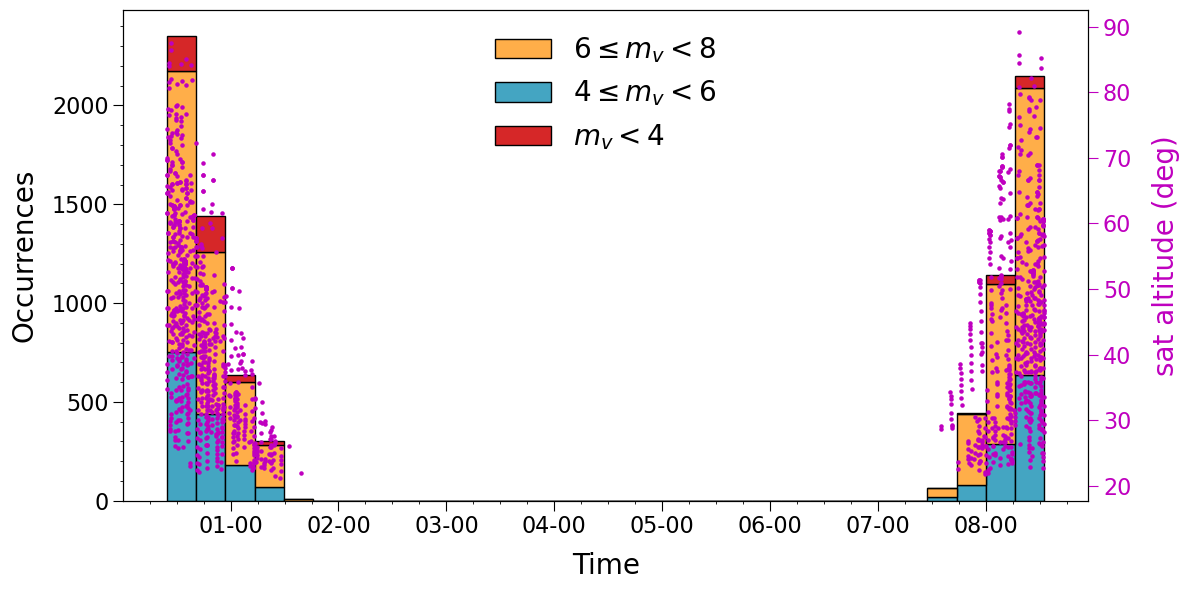

In [92]:
def time_seq_satalt(savefig=False, alt='sat'):

    fig, ax = plt.subplots(1, 1, figsize=[12,6])

    subset = df[['JD0', 'vmag', 'alt', 'sun_alt']].sort_values('JD0')
    jds = subset['JD0']
    vmags = subset['vmag']
    
    times = Time(jds, format='jd') 
    ax.hist(times.datetime, bins=30, weights=vmags, fc='None')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vmags):
        if vm < 4:
            t4.append(jds[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(jds[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(jds[i])
            v8.append(vm)

    t8 = Time(t8, format='jd').datetime
    t6 = Time(t6, format='jd').datetime
    t4 = Time(t4, format='jd').datetime

    cols = ['#44a5c2', '#ffae49', 'C3']
    labs = [r'$4 \leq m_v < 6$', r'$6 \leq m_v < 8$', r'$m_v < 4$']
    ax.hist([t8,t6,t4], bins=30, weights=[v8,v6,v4], color=cols, label=labs, ec='k', stacked=True)

    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], 
        loc='upper center', fontsize=20, frameon=False) 

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='out', right=False)
    ax.tick_params(axis='x', which='both', direction='out', top=False)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Time', fontsize=20, labelpad=10)
    
    
    # Altitudes
    twin = ax.twinx()
    
    if alt=='sun':
        twin.scatter(times.datetime, subset['sun_alt'], s=5, c='m')
    else:
        twin.scatter(times.datetime, subset['alt'], s=5, c='m')
        
    twin.tick_params(axis='y', which='major', length=7, labelsize=16)
    twin.set_ylabel(f'{alt} altitude (deg)', fontsize=20, labelpad=15)
    twin.yaxis.label.set_color('m')
    twin.tick_params(axis='y', colors='m')

    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}time_seq_{alt}alt.png', dpi=300, bbox_inches='tight')
    plt.show()
    

time_seq_satalt(savefig=False, alt='sat')

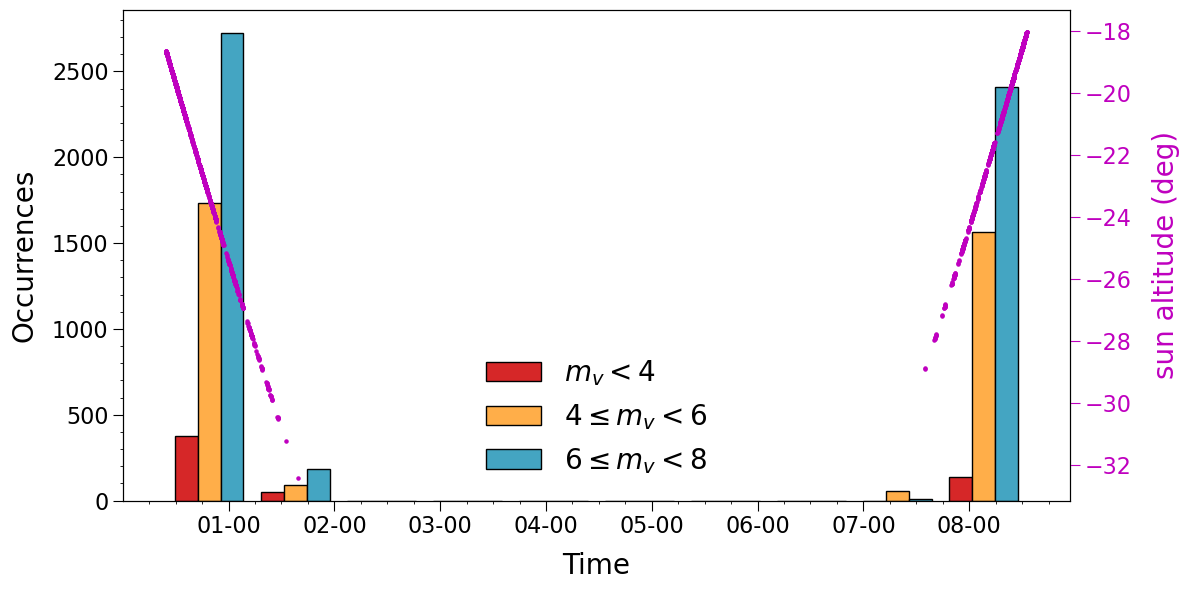

In [21]:
def time_seq_satalt(normtype='550', alt='sat', savefig=False):

    fig, ax = plt.subplots(1, 1, figsize=[12,6])
    column = f'vmag_norm_{normtype}'

    subset = df[['JD0', column, 'alt', 'sun_alt']].sort_values('JD0')
    jds = subset['JD0']
    vmags = subset[column]
    
    times = Time(jds, format='jd') 
    ax.hist(times.datetime, bins=30, weights=vmags, fc='None')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vmags):
        if vm < 4:
            t4.append(jds[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(jds[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(jds[i])
            v8.append(vm)

    t8 = Time(t8, format='jd').datetime
    t6 = Time(t6, format='jd').datetime
    t4 = Time(t4, format='jd').datetime

    cols = ['C3', '#ffae49', '#44a5c2']
    labs = [r'$m_v < 4$', r'$4 \leq m_v < 6$', r'$6 \leq m_v < 8$']
    ax.hist([t4,t6,t8], weights=[v4,v6,v8], color=cols, label=labs, ec='k')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(fontsize=20, frameon=False)

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='out', right=False)
    ax.tick_params(axis='x', which='both', direction='out', top=False)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Time', fontsize=20, labelpad=10)
    
    
    # Altitudes
    twin = ax.twinx()
    
    if alt=='sun':
        twin.scatter(times.datetime, subset['sun_alt'], s=5, c='m')
    else:
        twin.scatter(times.datetime, subset['alt'], s=5, c='m', alpha=0.3)
        
    twin.tick_params(axis='y', which='major', length=7, labelsize=16)
    twin.set_ylabel(f'{alt} altitude (deg)', fontsize=20, labelpad=15)
    twin.yaxis.label.set_color('m')
    twin.tick_params(axis='y', colors='m')

    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}time_seq_{alt}alt_{normtype}.png', dpi=300, bbox_inches='tight')
    plt.show()
    

time_seq_satalt(normtype='1000', alt='sun', savefig=True)

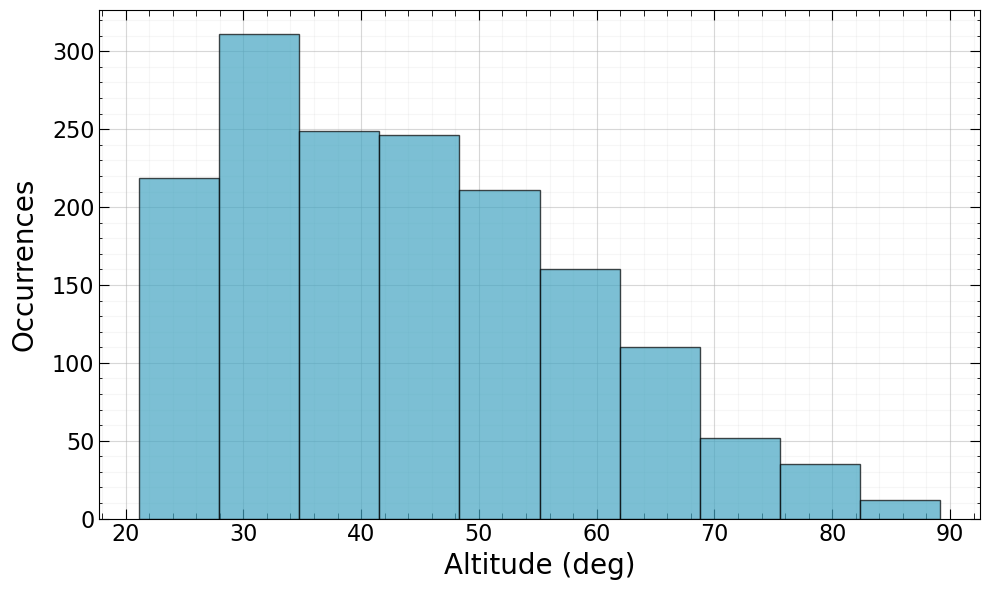

In [88]:
def alt_hist(savefig=False):
    
    fig, ax = plt.subplots(1, 1, figsize=[10,6])
                        
    n_bins = 10
    ax.hist(df.alt, n_bins, fc='#44a5c2', alpha=0.7, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Altitude (deg)', fontsize=20)
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_alt.png', dpi=300, bbox_inches='tight')
    plt.show()
    
alt_hist(savefig=True)

AttributeError: 'Text' object has no property 'labelpad'

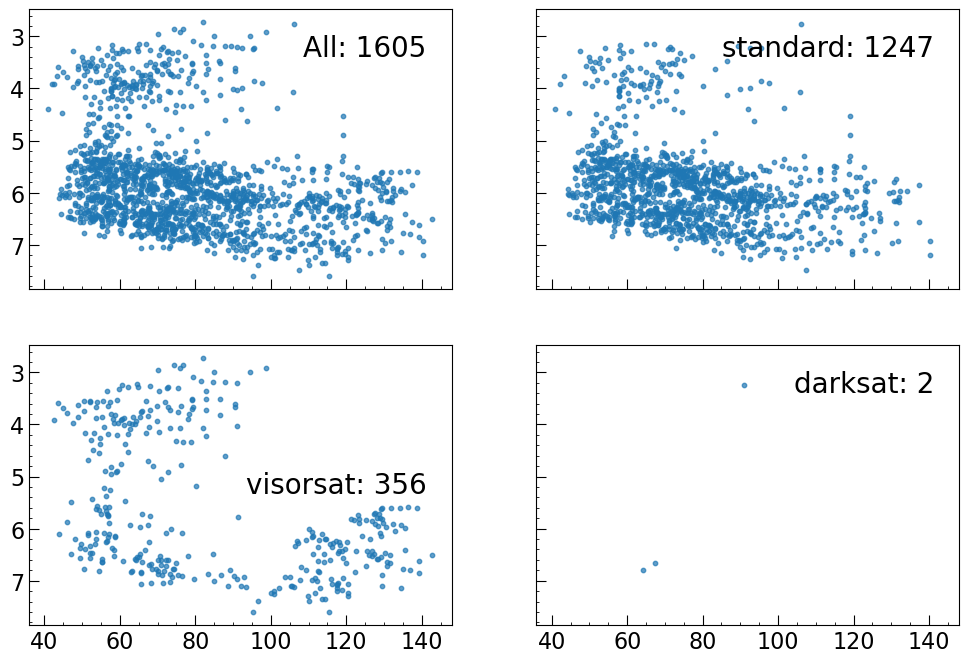

In [41]:
def phase_angle(savefig=False):
    
    fig, axs = plt.subplots(2, 2, figsize=[12,8], sharey=True, sharex=True)

    axs[0,0].scatter(df.phase_angle, df.vmag_norm_1000, s=10, c='C0', alpha=0.7, label=f'All: {len(df)}')
    axs[0,0].invert_yaxis()

    for sattype, ax in zip(['standard', 'visorsat', 'darksat'], axs.ravel()[1:]):
        ax.scatter(df[df['type']==sattype].phase_angle, df[df['type']==sattype].vmag_norm_1000, 
                  label=f"{sattype}: {len(df[df['type']==sattype])}", s=10, c='C0', alpha=0.7)

    for ax in axs.flat:
        ax.minorticks_on()
        ax.tick_params(axis='y', which='both', direction='in', right=False)
        ax.tick_params(axis='x', which='both', direction='in', top=False)
        ax.tick_params(axis='both', which='major', length=7, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=2)
        ax.legend(fontsize=20, frameon=False)

    fig.supylabel(r'Range normalized $m_v$ (1000km)', fontsize=20, labelpad=10)
    axs[1,0].set_xlabel('Phase angle (deg)', fontsize=20, labelpad=10)
    axs[1,1].set_xlabel('Phase angle (deg)', fontsize=20, labelpad=10)

    plt.tight_layout() 
    if savefig:
        plt.savefig(f'{savedir}phase_angle.png', dpi=300, bbox_inches='tight')
    plt.show()
    
phase_angle(savefig=True)

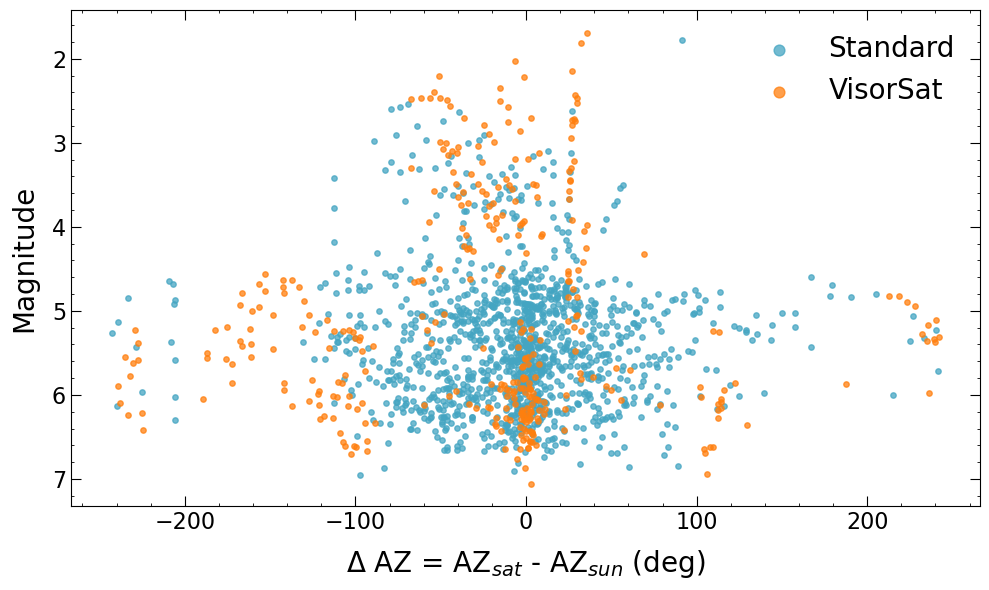

In [115]:
def az_diff(savefig=False):
    
    # Should expect to see brightest magnitudes at az_diff = 0
    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    subset = df[df['type'] == 'standard'][['vmag', 'az', 'sun_az']]
    diff = subset.az - subset.sun_az
    ax.scatter(diff, subset.vmag, c='#44a5c2', s=15, alpha=0.75, label='Standard')
    
    subset = df[df['type'] == 'visorsat'][['vmag', 'az', 'sun_az']]
    diff = subset.az - subset.sun_az
    ax.scatter(diff, subset.vmag, c='C1', s=15, alpha=0.75, label='VisorSat')

    leg = ax.legend(fontsize=20, markerscale=2, frameon=False)
    ax.invert_yaxis()

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='in', right=True)
    ax.tick_params(axis='x', which='both', direction='in', top=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Magnitude', labelpad=10, fontsize=20)
    ax.set_xlabel(r'$\Delta$ AZ = AZ$_{sat}$ - AZ$_{sun}$ (deg)', fontsize=20, labelpad=10)
    
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}az_diff.png', dpi=300, bbox_inches='tight')
    plt.show()

    
az_diff(savefig=True)

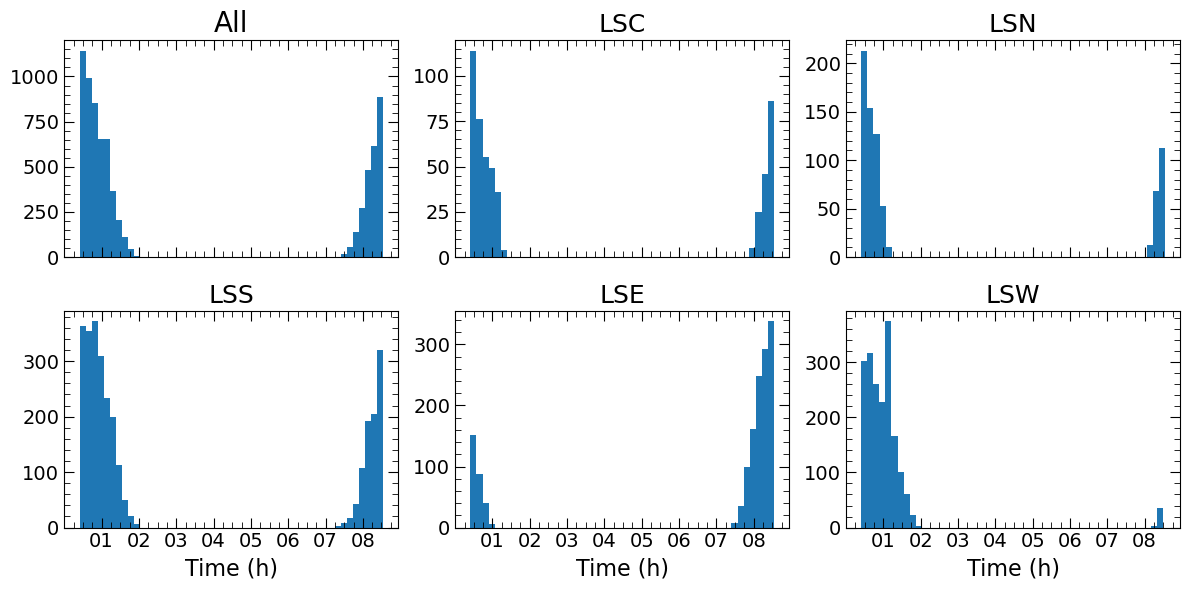

In [169]:
def affected_images(savefig=False):

    fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
    camids = ['LSC', 'LSN', 'LSS', 'LSE', 'LSW']

    all_jds = []
    all_satnums = []

    for (ax, camid) in zip(axs.ravel()[1:], camids):
        p = reduce_passages(camid)

        lstseqs = list(p.keys())
        jd0 = int(lstseqs[0])
        jd1 = int(lstseqs[-1])
        img_range = np.arange(jd0, jd1+1)

        satnums = []
        for lstseq in img_range:
            curlstseq = str(lstseq)
            if curlstseq in p:
                x = len(p[curlstseq])
                satnums.append(x)
            else:
                satnums.append(0)
        all_satnums.extend(satnums)

        sat0 = list(p[lstseqs[0]])[0]
        sat1 = list(p[lstseqs[-1]])[0]
        t0 = p[lstseqs[0]][sat0]['start']['jd']
        t1 = p[lstseqs[-1]][sat1]['start']['jd']

        jds = np.linspace(t0, t1, len(img_range), endpoint=True)
        times = Time(jds, format='jd') 
        all_jds.extend(jds)
        ax.hist(times.datetime, bins=50, weights=satnums)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.set_title(camid, fontsize=18)


    all_times = Time(all_jds, format='jd')
    axs[0,0].hist(all_times.datetime, bins=50, weights=all_satnums)
    axs[0,0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    axs[0,0].set_title('All', fontsize=20)
    
    for ax in axs.ravel()[3:]:
        ax.set_xlabel('Time (h)', fontsize=16)
    
    for ax in axs.flat:
        ax.minorticks_on()
        ax.tick_params(axis='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=7, labelsize=14)
        ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=4)
        
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}affected_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
affected_images(savefig=True)